In [1]:
import sys, os, h5py, pickle, warnings, subprocess
sys.path.append('/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs') #path where to find the lsst util
from opsimUtils import *

from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.maf.utils import m52snr, radec2pix

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from pylab import cm
import time
from itertools import groupby

from SNclassification_metric import *
%matplotlib inline

In [2]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRate_redshift_v1.7'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))

resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
surveyDuration = 1 
init = 1 
sqlconstraint = '( filter= "g" or  filter = "r" or filter="i")'
sqlconstraint+='and night>{} and night < {} '.format(init*365.25,(init+surveyDuration)*365.25 )
sqlconstraint+='and note like "DD%"'

In [4]:
import glob

workpath = os.getcwd()
os.chdir(dbDir)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps/'
os.chdir(workpath) # change back to work directory
dblist_all.sort()

In [5]:
dblist_all[0]

'baseline_nexp1_v1.7_10yrs.db'

In [6]:
dbname = dblist_all[0]
opsdb = db.OpsimDatabase(dbDir+dbname)
coo={'ra':np.array([149.72403071]),'dec':np.array([2.30812595])}
slicer = slicers.UserPointsSlicer(coo['ra'], coo['dec'], latLonDeg=True, badval=0)
metric = getDataMetric(colname=['night', 'observationStartMJD', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'filter','visitExposureTime','visitTime','note'])
# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>365.25 and night < 730.5 and note like "DD%" for columns ['note', 'visitTime', 'fiveSigmaDepth', 'night', 'visitExposureTime', 'fieldRA', 'filter', 'fieldDec', 'observationStartMJD']
Found 5722 visits
Running:  ['Sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [7]:
data = Sky.metricValues.data

# create DataFrame from ndarrays
df = pd.concat( [pd.DataFrame(d) for d in data], ignore_index=True, )

In [8]:
df

,note,visitTime,fiveSigmaDepth,night,visitExposureTime,fieldRA,filter,fieldDec,observationStartMJD
0,DD:COSMOS,31.0,23.789254,500,30.0,150.353768,i,1.549694,60353.159656
1,DD:COSMOS,31.0,23.515029,519,30.0,150.626169,i,2.642504,60372.110274
2,DD:COSMOS,31.0,23.492588,496,30.0,150.553481,r,1.841210,60349.152259
3,DD:COSMOS,31.0,23.425698,496,30.0,150.553481,r,1.841210,60349.152641
4,DD:COSMOS,31.0,23.427100,496,30.0,150.553481,r,1.841210,60349.153023
...,...,...,...,...,...,...,...,...,...
935,DD:COSMOS,31.0,23.602346,471,30.0,149.932213,i,2.715372,60324.218533
936,DD:COSMOS,31.0,23.600782,471,30.0,149.932213,i,2.715372,60324.218151
937,DD:COSMOS,31.0,23.597344,471,30.0,149.932213,i,2.715372,60324.217769
938,DD:COSMOS,31.0,24.091269,447,30.0,149.544441,r,2.262656,60300.316829


To properly coadd the visits in the same night we operate some edits on the dataframe:

In [9]:
keygroup = ['filter', 'night']

df.sort_values(by=keygroup, ascending=[
                 True, True], inplace=True)

coadd_df = df.groupby(keygroup).agg({'visitExposureTime': ['sum'],
                                       'visitTime': ['sum'],
                                       'observationStartMJD': ['mean'],
                                       'fieldRA': ['mean'],
                                       'fieldDec': ['mean'],
                                       'fiveSigmaDepth': ['mean']}).reset_index()

coadd_df.columns = ['filter','night', 'visitExposureTime','visitTime',
                    'observationStartMJD', 'fieldRA', 'fieldDec',
                    'fiveSigmaDepth']

coadd_df.loc[:, 'fiveSigmaDepth'] += 1.25 * \
    np.log10(coadd_df['visitTime']/30.)

coadd_df.sort_values(by=['filter', 'night'], ascending=[
                     True, True], inplace=True)

In [ ]:
coadd_df

Text(0, 0.5, 'DEC')

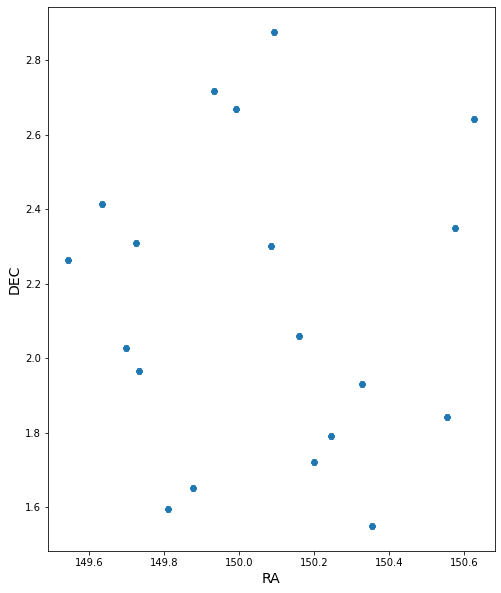

In [10]:
plt.figure(figsize=(8,10))
plt.plot(coadd_df['fieldRA'],coadd_df['fieldDec'],'H')
plt.xlabel('RA', fontsize=14)
plt.ylabel('DEC',fontsize=14)

### TEST REDSHIFT (1 SN tutti i redshift)

In [4]:
sngroups ={'II':{'II':(['2004et'],100)}}
slicer = generateSNPopSlicer(templates= sngroups, t_start=0, 
                             t_end=365, t_step=10, n_events=37, seed=42, zmin=0.1, zmax=1,zstep=0.1,
                             coo={'ra':np.array([149.72403071]),'dec':np.array([2.30812595])})
print('z_range = {}'.format(slicer.slicePoints['zrange']))
print('explosion epochs = {}'.format(np.sort(slicer.slicePoints['explosion_times'])))

Reading SN light curve templates
z_range = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
explosion epochs = [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360]


In [5]:
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)
process = []
import multiprocessing as mp
start_time = time.time()
for run in ['baseline_nexp1_v1.7_10yrs']:
    metriclc = SNclassification_metric(metricName='test',LCfolder='./LC_{}'.format(run), mjdCol='observationStartMJD',\
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec',\
                              surveyDuration=surveyDuration,\
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, \
                              ndetect=3,nclass=5,dataout=True)
    metriclc_trans= metricBundles.MetricBundle(metriclc, slicer, sqlconstraint)
    bundleDict={'test':metriclc_trans}

    warnings.filterwarnings('ignore')
    metriclc_trans.setRunName(run)
    bgrouplc = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], outDir, resultDbs[run])
    p=mp.Process(target=bgrouplc.runAll)
    p.start()
    process.append(p)
for pr in process:
    pr.join()    
print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
print('####################\n')

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>365.25 and night < 730.5 and note like "DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'visitExposureTime', 'filter', 'visitTime', 'fieldRA', 'night', 'fieldDec']
Found 5722 visits
Running:  ['test']
['./template/snlc_2004et_z=0.9_temp.ascii', '2004et', '0.9']
['./template/snlc_2004et_z=0.1_temp.ascii', '2004et', '0.1']
['./template/snlc_2004et_z=0.2_temp.ascii', '2004et', '0.2']
['./template/snlc_2004et_z=0.3_temp.ascii', '2004et', '0.3']
['./template/snlc_2004et_z=0.4_temp.ascii', '2004et', '0.4']
['./template/snlc_2004et_z=0.5_temp.ascii', '2004et', '0.5']
['./template/snlc_2004et_z=0.6_temp.ascii', '2004et', '0.6']
['./template/snlc_2004et_z=0.7_temp.ascii', '2004et', '0.7']
['./template/snlc_2004et_z=0.8_temp.ascii', '2004et', '0.8']
________________________________________
total SNe simulated: 333; lost SNe: 180
z= 0.1 type=Ia
Detected=0 UnDetected=0 filtered_class

### TEST tutte le SNe 1 redshift

In [6]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRate_SN_v1.7'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))

resultsDb = db.ResultsDb(outDir=outDir)

In [7]:
outDir

'/home/idies/workspace/Storage/fragosta/persistent/MAFOutput/MetricData/SNRate_SN_v1.7'

In [8]:
sngroups ={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                    'IaBright':(['1991T','1999ee'],10), 
                    'IaFaint':(['1991bg'],15), 
                    'Iapec':(['2000cx','2002cx'],5)},
              'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                    'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                    'IIL':(['1992H'],10),                           # 10
                    'IIb':(['1993J','2008ax'],10),                  # 10
                    'II87A':(['1987A'],10)},                        # 10
              'IIn':{'IIn':(['2010jl'],45),
                     'IIna':(['1998S'],45), 
                     'IIpec':(['1997cy','2005gj'],10)},
              'Ibc':{'Ib':(['2009jf','2008D'],27), 
                     'Ic':(['1994I','2004aw','2007gr'],68), 
                     'IcBL':(['1998bw'],5)}, 
              'SLSN' : {'SLSN':(['2008es'],100)}}
slicer = generateSNPopSlicer(templates= sngroups, t_start=0, 
                             t_end=365, t_step=10, n_events=37, seed=42, zmin=0.1, zmax=0.3,zstep=0.1,
                             coo={'ra':np.array([149.72403071]),'dec':np.array([2.30812595])})
print('z_range = {}'.format(slicer.slicePoints['zrange']))
print('explosion epochs = {}'.format(np.sort(slicer.slicePoints['explosion_times'])))

Reading SN light curve templates
z_range = [0.1 0.2]
explosion epochs = [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360]


In [9]:
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)
process = []
import multiprocessing as mp
start_time = time.time()
for run in ['baseline_nexp1_v1.7_10yrs']:
    metriclc = SNclassification_metric(metricName='test',LCfolder='./LC_{}'.format(run), mjdCol='observationStartMJD',\
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec',\
                              surveyDuration=surveyDuration,\
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, \
                              ndetect=3,nclass=5,dataout=True)
    metriclc_trans= metricBundles.MetricBundle(metriclc, slicer, sqlconstraint)
    bundleDict={'test':metriclc_trans}

    warnings.filterwarnings('ignore')
    metriclc_trans.setRunName(run)
    bgrouplc = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], outDir, resultDbs[run])
    p=mp.Process(target=bgrouplc.runAll)
    p.start()
    process.append(p)
for pr in process:
    pr.join()    
print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
print('####################\n')

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>365.25 and night < 730.5 and note like "DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'visitExposureTime', 'filter', 'visitTime', 'fieldRA', 'night', 'fieldDec']
Found 5722 visits
Running:  ['test']
['./template/snlc_2002cx_z=0.1_temp.ascii', '2002cx', '0.1']
['./template/snlc_2004et_z=0.1_temp.ascii', '2004et', '0.1']
['./template/snlc_1999br_z=0.1_temp.ascii', '1999br', '0.1']
['./template/snlc_1999gi_z=0.1_temp.ascii', '1999gi', '0.1']
['./template/snlc_1992H_z=0.1_temp.ascii', '1992H', '0.1']
['./template/snlc_2008ax_z=0.1_temp.ascii', '2008ax', '0.1']
['./template/snlc_1987A_z=0.1_temp.ascii', '1987A', '0.1']
['./template/snlc_1998S_z=0.1_temp.ascii', '1998S', '0.1']
['./template/snlc_2005gj_z=0.1_temp.ascii', '2005gj', '0.1']
['./template/snlc_2009jf_z=0.1_temp.ascii', '2009jf', '0.1']
['./template/snlc_1994I_z=0.1_temp.ascii', '1994I', '0.1']
['./template/snlc_20

In [23]:
resultDbs = getResultsDbs(outDir)
# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs.keys())
bundleDicts = {}
for runName in ['baseline_nexp1_v1.7_10yrs']:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, outDir)

In [26]:
bundleDicts['baseline_nexp1_v1.7_10yrs'].keys()

dict_keys([(1, '_baseline_nexp1_v1.7_10yrs'), (2, '_baseline_nexp1_v1.7_10yrs')])

In [27]:
df17={}
coo_df={}
for opsim in  ['baseline_nexp1_v1.7_10yrs']:
    df17[opsim]={}
    coo_df[opsim]={}
    
    bmetric =[(2, '_baseline_nexp1_v1.7_10yrs')]
    for metric in bmetric:
        coo_df[opsim][metric[1]] = np.column_stack((bundleDicts[opsim][metric].slicer.slicePoints['ra'][np.where(bundleDicts[opsim][metric].metricValues.mask==False)]
                                          ,bundleDicts[opsim][metric].slicer.slicePoints['dec'][np.where(bundleDicts[opsim][metric].metricValues.mask==False)]))
        arr=bundleDicts[opsim][metric].metricValues.data
        arr_=arr[np.where(arr!=None)]
        df17[opsim][metric[1]] = pd.DataFrame.from_records(arr_)

In [11]:
lc_list = glob.glob('LC_baseline_nexp1_v1.7_10yrs/*dat')

obs={l:{}for l in lc_list}
coo = {l:[]for l in lc_list}
expl = []
for lobs in obs.keys():
    expl.append(float(lobs.split('_')[-2]))
    f= open(lobs,'r')
    r= f.read()
    l =r.split('\n')
    idx_z = np.where(np.array(l)=='REDSHIFT_FINAL:  0.1 +- 0.700 (CMB)')
    loc = l[3].split()
    ra = float(loc[1])
    loc = l[4].split()
    dec = float(loc[1])
    coo[lobs].append([ra,dec])    
    z=float(np.array(r.split('\n'))[6].split()[1])
    idx_in = np.where(np.array(l)=='VARLIST:  MJD  FLT FIELD   FLUXCAL   FLUXCALERR   SNR    MAG     MAGERR ')
    idx_end= np.where(np.array(l)=='END: ')
    e_obs,m_obs,err_obs,f_obs=[],[],[],[]
    for i in np.arange(idx_in[0][0]+1,idx_end[0][0],1):
        e_obs.append(float(l[i].split()[1]))
        m_obs.append(float(l[i].split()[-2]))
        err_obs.append(float(l[i].split()[-1]))
        f_obs.append(l[i].split()[2])
    obs[lobs].update({z:{'epoch':np.array(e_obs),
                      'mag':np.array(m_obs),
                      'mag_err':np.array(err_obs),'filter':np.array(f_obs),'coo': [ra,dec]}})
    

In [29]:
lc_list[250:260]

['LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60294.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60304.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60314.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60324.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60334.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60344.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60354.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60364.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60374.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.2_60384.28.dat']

In [12]:
temp = template_lc(sn_group=sngroups ,
                               z_min=0.1,z_max= 0.9,z_step=0.1)
obs_template = temp.run()

Reading SN light curve templates


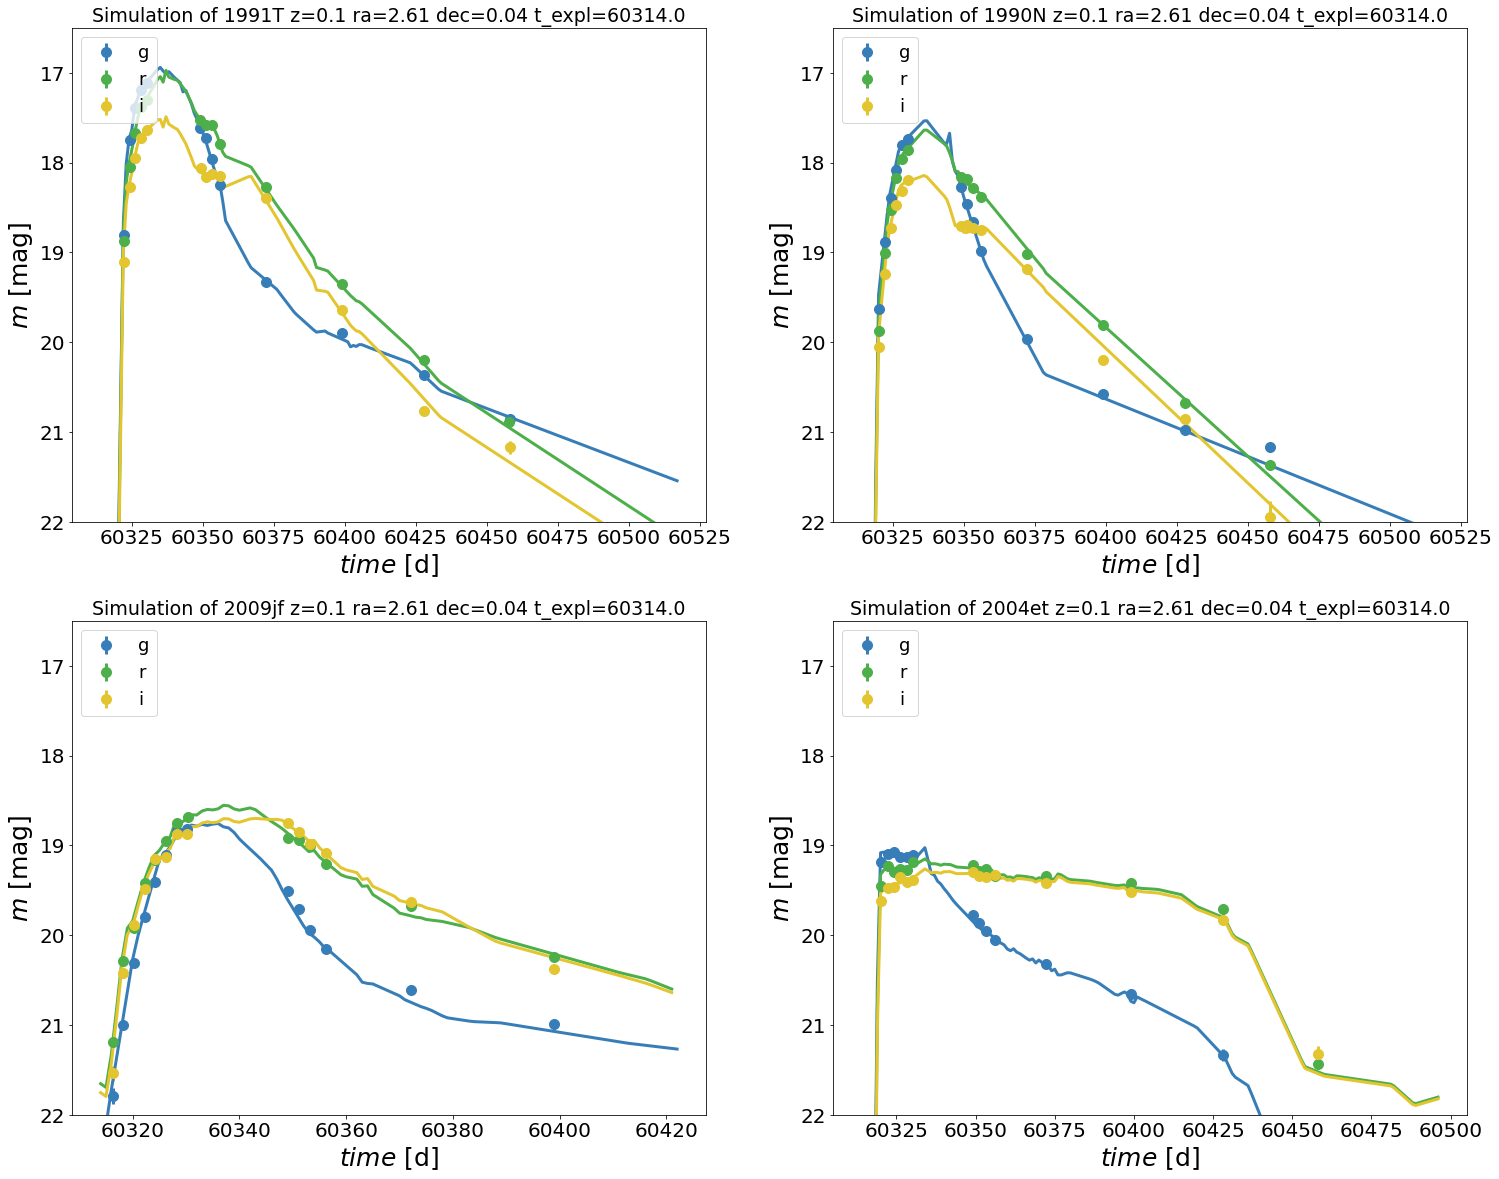

In [14]:
color = ['#377eb8','#4daf4a', '#e3c530']
ty=['1991T','1990N','2009jf','2004et']
llist=['LC_baseline_nexp1_v1.7_10yrs/LSST_1991T_0.1_60314.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_1990N_0.1_60314.28.dat',
      'LC_baseline_nexp1_v1.7_10yrs/LSST_2009jf_0.1_60314.28.dat',
      'LC_baseline_nexp1_v1.7_10yrs/LSST_2004et_0.1_60314.28.dat']
fig, axes = plt.subplots(2,2,figsize=(25,20))
for i,axs in enumerate(axes.flatten()):
    for j, f in enumerate(['g','r','i']):
        c=color[j]
        t_expl = float(llist[i].split('_')[-1].split('.')[0])
        z = float(llist[i].split('_')[-2])
        filters=obs[llist[i]][z]['filter']==f
        mag =obs_template['magobs'][ty[i]][z][f]
        maglc =obs[llist[i]][z]['mag'][filters]
        magerrlc =obs[llist[i]][z]['mag_err'][filters]
        
        if np.size(obs[llist[i]][z]['epoch'][filters])>0:
            ph = obs_template['phobs'][ty[i]][z][f]+t_expl-obs_template['phobs'][ty[i]][z][f][0]
            phlc = obs[llist[i]][z]['epoch'][filters]
            axs.errorbar(phlc, maglc,yerr=5*2.5/(1/(np.exp(magerrlc/2.5)-1)),fmt='o',elinewidth=3,color=c,markersize=10,label=f)
            axs.plot(ph, mag,'-',lw=3,color=c)
        axs.invert_yaxis()
        axs.set_ylim([22,16.5])
        #axs.set_xlim([60200,60400])
        axs.set_xlabel(r'$time$ [d]',fontsize=25)
        axs.set_ylabel(r'$m$ [mag]',fontsize=25)
        axs.set_title(r'Simulation of {} z={} ra={} dec={} t_expl={}'.format(ty[i],z,
        np.round(obs[llist[i]][z]['coo'][0],2),np.round(obs[llist[i]][z]['coo'][1],2), t_expl),fontsize=19)
        axs.tick_params('both', labelsize=20)
    #if i ==0:
        axs.legend(loc=2,fontsize=18)
